In [1]:
# needed imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

In [2]:
# sets default font parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})

In [3]:
# list of numbers of points sampled
ns = np.array(range(4,30+1))

In [4]:
# loads MBC method data for all sampling densities (100k runs)
var_u_100k = sio.loadmat('Data/full_uniform_100k_MBC.mat')['full_uniform_100k_MBC'] 
var_c_100k = sio.loadmat('Data/full_center_100k_MBC.mat')['full_center_100k_MBC'] 
var_d_100k = sio.loadmat('Data/full_decay_100k_MBC.mat')['full_decay_100k_MBC'] 
var_w_100k = sio.loadmat('Data/full_whacky_100k_MBC.mat')['full_whacky_100k_MBC']

In [5]:
# loads CLT and ST method data for all sampling densities (1 million runs)
var_u_1M_cltst = sio.loadmat('Data/full_uniform_1M_cltst.mat')['full_uniform_1M_cltst']
var_c_1M_cltst = sio.loadmat('Data/full_center_1M_cltst.mat')['full_center_1M_cltst']
var_d_1M_cltst = sio.loadmat('Data/full_decay_1M_cltst.mat')['full_decay_1M_cltst']
var_w_1M_cltst = sio.loadmat('Data/full_whacky_1M_cltst.mat')['full_whacky_1M_cltst']

In [6]:
# color list
colors = ['#ff3322', '#ff9900', '#2277ee', '#ff9999', '#ffdd00', '#000099']

In [7]:
# Plots distribution with mean line and variance margins
# takes in 'ax': plot axes, 'x': plot's x-values, 'f': distribution density values,
# 'ylims': y-limits as vector, 'tag': title string
# returns nothing, produces plot

def plot_dist(ax, x, f, ylims, tag):

    plt.plot(x, f, colors[2]) # plot distribution
    # fill space below distribution
    plt.fill_between(x, f, np.zeros(len(x)), alpha=0.2, 
                     edgecolor=colors[2], facecolor=colors[2], linewidth=0, antialiased=True)
    
    mean = np.round(sum([x[i]*f[i] for i in range(1022)]),5)/1022 # calculate mean
    var = np.round(sum([(x[i]-mean)**2*f[i] for i in range(1022)]),5)/1022 # calculate variance
    plt.plot(mean*np.ones(2), np.array([ylims[0],ylims[1]]), '--k') # add line at distribution mean
    plt.plot((mean-var)*np.ones(2), np.array([ylims[0],ylims[1]]), ':k') # add lower variance margin
    plt.plot((mean+var)*np.ones(2), np.array([ylims[0],ylims[1]]), ':k') # add upper variance margin
    
    ax.set_title(tag, fontsize=19.5) # add title
    ax.set_xlabel(r'x') # add x-label
    ax.set_ylabel(r'Density $\rho$') # add y-label
    ax.set_xlim([0,1]) # set x-limits
    ax.set_ylim(ylims) # set y-limits

In [8]:
# Plots absolute performances of all methods over number of points sampled (without error bars)
# takes in 'ax': plot axes, 'var': all-method performance data, 'var_ext': full CLT data,
# 'ylims': y-limits as vector, 'tag': title string
# returns nothing, produces plot

def plot_abs(ax, var, var_ext, ylims, tag):
    
    # calculates and plots absolute performances of CLT method over numbers of points sampled
    plt.plot(ns, [np.mean(var_ext[0][i][:]) for i in range(len(ns))], colors[2]) # clt
    plt.plot(ns, [np.mean(var_ext[1][i][:]) for i in range(len(ns))], colors[5]) # st
    
    for k in [0,1,3,4]: # loops over indeces for all methods except clt
            # calculates and plots absolute performances over numbers of points sampled
            plt.plot(ns, [np.mean(var[k][i][:]) for i in range(len(ns))], colors[k])
    # plots line corresponding to uniform posterior assumption (baseline performance)
    plt.plot([4,30],1022*np.array([1/1022,1/1022]), '#333333', linestyle='--', label='Uniform Posterior')

    ax.set_title(tag, fontsize=19.5) # add title
    ax.set_xlabel(r'Number of Sampled Points') # add x-label
    ax.set_ylabel(r'Average Posterior at True $\mu$') # add y-label
    ax.set_xlim([4,30]) # set x-limits
    ax.set_ylim(ylims) # set y-limits
    ax.grid() # adds grid to plot

In [9]:
# Plots relative performances of all methods over number of points sampled (with error bars)
# takes in 'ax': plot axes, 'var': all-method performance data, 'var_ext': full CLT data,
# 'ylims': y-limits as vector, 'tag': title string
# returns nothing, produces plot

def plot_rel(ax, var, var_ext, ylims, tag):
    
    # initializes average performance matrix over methods and numbers of points sampled
    plts = np.zeros((6,len(ns)))
    # populates average performance matrix
    for k in [0,1,3,4]:
        plts[k] = [np.mean(var[k][j][:]) for j in range(len(ns))] # MBC methods
    plts[2] = [np.mean(var_ext[0][j][:]) for j in range(len(ns))] # clt
    plts[5] = [np.mean(var_ext[1][j][:]) for j in range(len(ns))] # st
    
    # creates vector of average performances of all methods over numbers of points sampled
    avgs = np.mean(plts, axis=0)
    # creates 6-order poly-fit of average performances of all methods over numbers of points sampled
    avgs = [np.poly1d(np.polyfit(ns, avgs, 6))(i) for i in ns]
    
    z = 2.576 # z-value corresponding to 99% confidence interval
    
    # calculates relative performance for CLT method
    rel = np.array([np.mean(var_ext[0][i][:])-avgs[i] for i in range(len(ns))])
    # calculated error bars for performance for CLT plot
    rel_err = np.array([np.std(var_ext[0][i][:])/np.sqrt(var_ext[0].shape[1]) for i in range(len(ns))])   
    # creates plot of relative performance for CLT method
    plt.plot(ns, rel, colors[2])
    # adds error bars to CLT plot
    plt.fill_between(ns, rel+z*rel_err,rel-z*rel_err, alpha=0.2, 
                     edgecolor=colors[2], facecolor=colors[2], linewidth=0, antialiased=True)
    
    # calculates relative performance for ST method
    rel = np.array([np.mean(var_ext[1][i][:])-avgs[i] for i in range(len(ns))])
    # calculated error bars for performance for ST plot
    rel_err = np.array([np.std(var_ext[1][i][:])/np.sqrt(var_ext[1].shape[1]) for i in range(len(ns))])   
    # creates plot of relative performance for ST method
    plt.plot(ns, rel, colors[5])
    # adds error bars to ST plot
    plt.fill_between(ns, rel+z*rel_err,rel-z*rel_err, alpha=0.2, 
                     edgecolor=colors[2], facecolor=colors[2], linewidth=0, antialiased=True)
        
    for k in [0,1,3,4]: # loops over indeces for all methods except clt and st
        # calculates relative performance
        rel = np.array([np.mean(var[k][i][:])-avgs[i] for i in range(len(ns))])
        # calculated error bars
        rel_err = np.array([np.std(var[k][i][:])/np.sqrt(var.shape[2]) for i in range(len(ns))]) 
        # creates plot of relative performance
        plt.plot(ns, rel, colors[k])
        # adds error bars to plot
        plt.fill_between(ns, rel+z*rel_err,rel-z*rel_err, alpha=0.2, 
                         edgecolor=colors[k], facecolor=colors[k], linewidth=0, antialiased=True)

    ax.set_title(tag, fontsize=19.5) # add title
    ax.set_xlabel(r'Number of Sampled Points') # add x-label
    ax.set_ylabel(r'Relative Avg. Post. at True $\mu$') # add y-label
    ax.set_xlim([4,30]) # set x-limits
    ax.set_ylim(ylims) # set y-limits
    ax.grid() # adds grid to plot

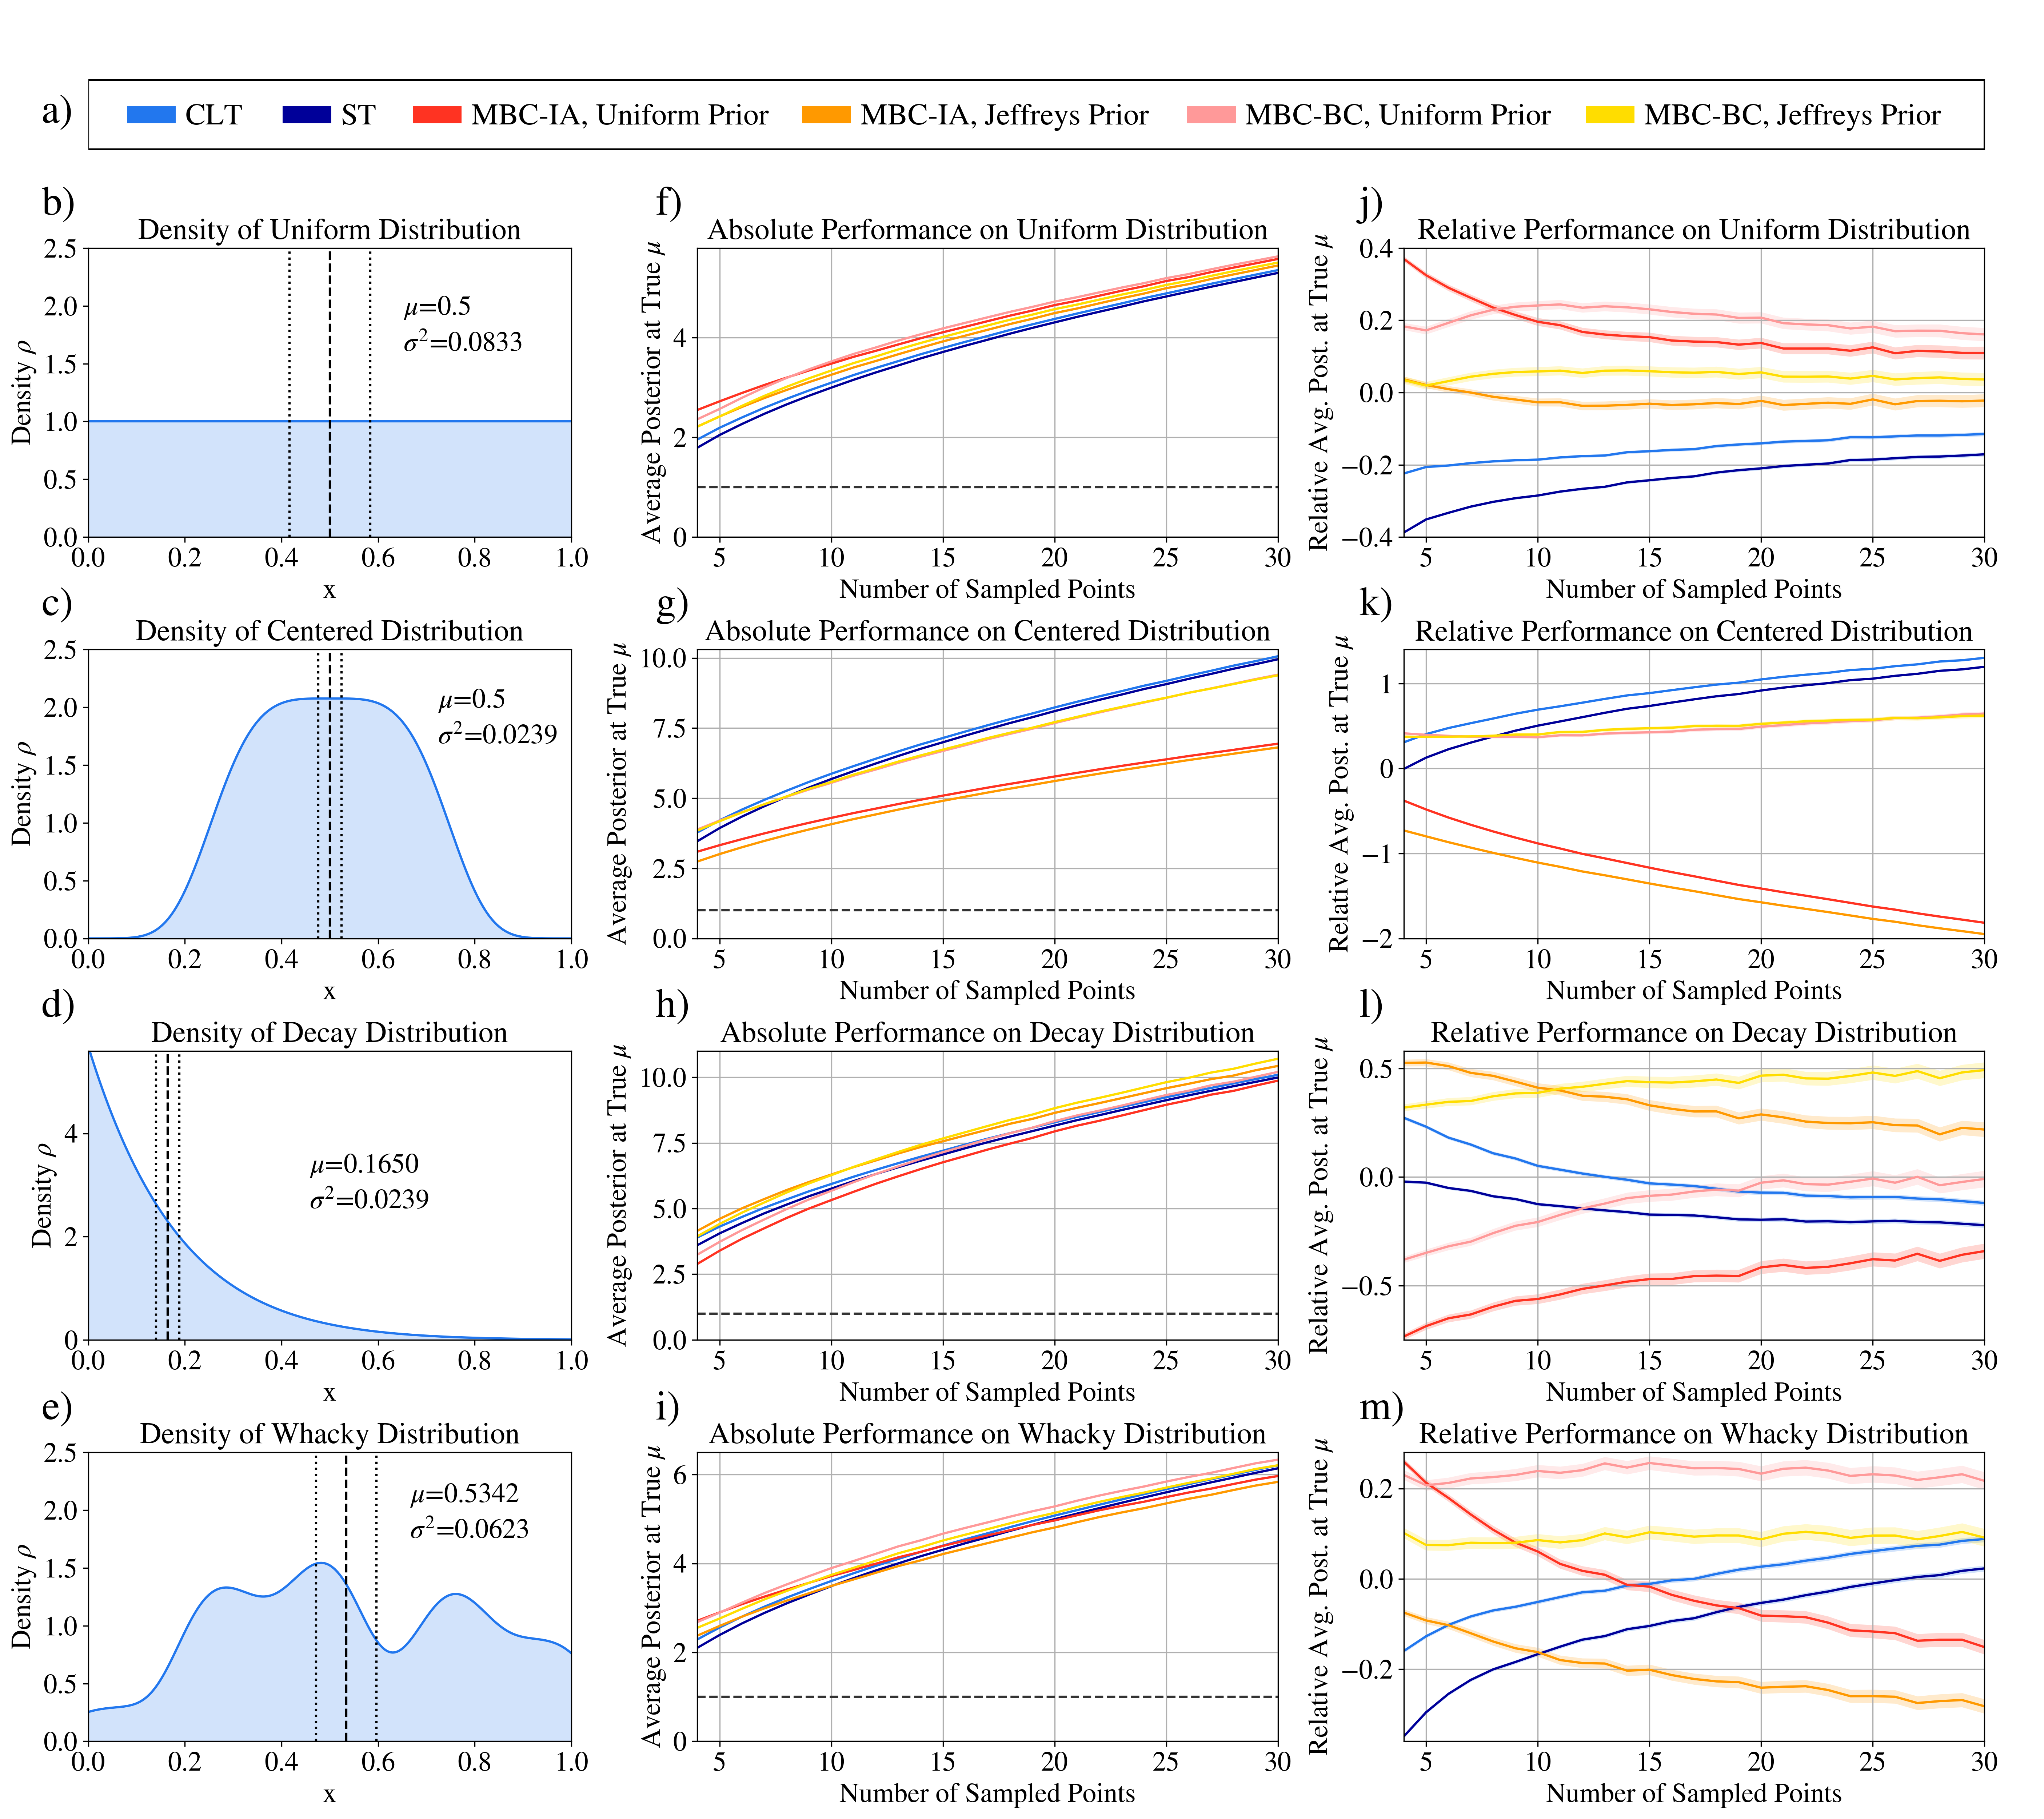

In [10]:
# sets figure/axis/grid sizes
fig, ax = plt.subplots(figsize=(23, 21), dpi=300)
ax.axis('off')
gs = GridSpec(nrows=95, ncols=80)

# ROW 0

# thin box for subfigure (a) legend
rect = patches.Rectangle((0, 0.92), 0.975, 0.04, edgecolor = 'black', facecolor = 'none',fill=False, lw=1)
ax.add_patch(rect)

# CLT legend
leg0 = 0.01
rect = patches.Rectangle((0.01+leg0, 0.935), 0.025, 0.01, edgecolor = 'none', facecolor = colors[2] ,fill=True, lw=0)
ax.add_patch(rect)
plt.text(0.04+leg0,0.9345,'CLT', fontsize=20)

# ST legend
leg0 = 0.09
rect = patches.Rectangle((0.01+leg0, 0.935), 0.025, 0.01, edgecolor = 'none', facecolor = colors[5] ,fill=True, lw=0)
ax.add_patch(rect)
plt.text(0.04+leg0,0.9345,'ST', fontsize=20)

# MBC-IA-UP legend
leg0 = 0.157
rect = patches.Rectangle((0.01+leg0, 0.935), 0.025, 0.01, edgecolor = 'none', facecolor = colors[0] ,fill=True, lw=0)
ax.add_patch(rect)
plt.text(0.04+leg0,0.9345,'MBC-IA, Uniform Prior', fontsize=20)

# MBC-IA-JP legend
leg0 = 0.357
rect = patches.Rectangle((0.01+leg0, 0.935), 0.025, 0.01, edgecolor = 'none', facecolor = colors[1] ,fill=True, lw=0)
ax.add_patch(rect)
plt.text(0.04+leg0,0.9345,'MBC-IA, Jeffreys Prior', fontsize=20)

# MBC-IA-UP legend
leg0 = 0.555
rect = patches.Rectangle((0.01+leg0, 0.935), 0.025, 0.01, edgecolor = 'none', facecolor = colors[3] ,fill=True, lw=0)
ax.add_patch(rect)
plt.text(0.04+leg0,0.9345,'MBC-BC, Uniform Prior', fontsize=20)

# MBC-IA-JP legend
leg0 = 0.76
rect = patches.Rectangle((0.01+leg0, 0.935), 0.025, 0.01, edgecolor = 'none', facecolor = colors[4] ,fill=True, lw=0)
ax.add_patch(rect)
plt.text(0.04+leg0,0.9345,'MBC-BC, Jeffreys Prior', fontsize=20)

vs = 13 # vertical spacing above row 1

# ROW 1:

# subfigure b)
ax1 = fig.add_subplot(gs[0+vs:16+vs, 0:20])
x = np.linspace(0,1,1022)
f1 = np.ones(1022)
f1 = f1/sum(f1)
plot_dist(ax1, x, 1022*f1, 1000*np.array([0,0.0025]), "Density of Uniform Distribution")

# subfigure f)
ax2 = fig.add_subplot(gs[0+vs:16+vs, 25:49])
plot_abs(ax2, 1022*var_u_100k, var_u_1M_cltst, 1000*np.array([0,0.0058]), 
         "Absolute Performance on Uniform Distribution")

# subfigure j)
ax3 = fig.add_subplot(gs[0+vs:16+vs, 54:78])
plot_rel(ax3, 1022*var_u_100k, var_u_1M_cltst, 1000*np.array([-0.0004,0.0004]), 
         "Relative Performance on Uniform Distribution")

# ROW 2:

# subfigure c)
ax4 = fig.add_subplot(gs[22+vs:38+vs, 0:20])
f2 = [np.exp(-200*(i-0.5)**4) for i in x]
f2 = f2/sum(f2)
plot_dist(ax4, x, 1022*f2, 1000*np.array([0,0.0025]), "Density of Centered Distribution")

# subfigure g)
ax5 = fig.add_subplot(gs[22+vs:38+vs, 25:49])
plot_abs(ax5, 1022*var_c_100k, var_c_1M_cltst, 1000*np.array([0,0.0103]), 
         "Absolute Performance on Centered Distribution")

# subfigure k)
ax6 = fig.add_subplot(gs[22+vs:38+vs, 54:78])
plot_rel(ax6, 1022*var_c_100k,  var_c_1M_cltst, 1000*np.array([-0.002,0.0014]), 
         "Relative Performance on Centered Distribution")

# ROW 3:

# subfigure d)
ax7 = fig.add_subplot(gs[44+vs:60+vs, 0:20])
f3 = [np.exp(-0.0026115*(i-0.5+8.5)**4) for i in x] # Let's stick with this one!
f3 = f3/sum(f3)
plot_dist(ax7, x, 1022*f3, 1000*np.array([0,0.0056]), "Density of Decay Distribution")

# subfigure h)
ax8 = fig.add_subplot(gs[44+vs:60+vs, 25:49])
plot_abs(ax8, 1022*var_d_100k,  var_d_1M_cltst, 1000*np.array([0,0.011]), 
         "Absolute Performance on Decay Distribution")

# # subfigure l)
ax9 = fig.add_subplot(gs[44+vs:60+vs, 54:78])
plot_rel(ax9, 1022*var_d_100k,  var_d_1M_cltst, 1000*np.array([-0.00075,0.00058]), 
         "Relative Performance on Decay Distribution")

# ROW 4:

# subfigure e)
ax10 = fig.add_subplot(gs[66+vs:82+vs, 0:20])
f4 = [np.exp(-(5*(i-1/8))**4)+4*np.exp(-(5*(i-3/8))**4)+2*np.exp(-(5*(i-5/8))**4)+3*np.exp(-(5*(i-7/8))**4) for i in x]
f4 = f4/sum(f4)
plot_dist(ax10, x, 1022*f4, 1000*np.array([0,0.0025]), "Density of Whacky Distribution")

# subfigure i)
ax11 = fig.add_subplot(gs[66+vs:82+vs, 25:49])
plot_abs(ax11, 1022*var_w_100k,  var_w_1M_cltst, 1000*np.array([0,0.0065]), 
         "Absolute Performance on Whacky Distribution")

# subfigure m)
ax12 = fig.add_subplot(gs[66+vs:82+vs, 54:78])
plot_rel(ax12, 1022*var_w_100k,  var_w_1M_cltst, 1000*np.array([-0.00036,0.00028]), 
         "Relative Performance on Whacky Distribution")

# Labels for letters a) - m)
xlpos = np.array([-57, -29.5, 2])
ylpos = np.array([2.967, 2.08, 1.19, 0.299])+0.055*np.ones(4)
plt.text(-57,3.226,'a)', fontsize=27)
plt.text(xlpos[0],ylpos[0],'b)', fontsize=27)
plt.text(xlpos[0],ylpos[1],'c)', fontsize=27)
plt.text(xlpos[0],ylpos[2],'d)', fontsize=27)
plt.text(xlpos[0],ylpos[3],'e)', fontsize=27)
plt.text(xlpos[1],ylpos[0],'f)', fontsize=27)
plt.text(xlpos[1],ylpos[1],'g)', fontsize=27)
plt.text(xlpos[1],ylpos[2],'h)', fontsize=27)
plt.text(xlpos[1],ylpos[3],'i)', fontsize=27)
plt.text(xlpos[2],ylpos[0],'j)', fontsize=27)
plt.text(xlpos[2],ylpos[1],'k)', fontsize=27)
plt.text(xlpos[2],ylpos[2],'l)', fontsize=27)
plt.text(xlpos[2],ylpos[3],'m)', fontsize=27)

# Uniform Moments Label
plt.text(-40.8,2.8,'$\mu$=0.5', fontsize=18)
plt.text(-40.8,2.8-0.08,'$\sigma^2$=0.0833', fontsize=18)

# Centered Moments Label
plt.text(-39.25,1.93,'$\mu$=0.5', fontsize=18)
plt.text(-39.25,1.93-0.08,'$\sigma^2$=0.0239', fontsize=18)

# Decay Moments Label
plt.text(-45,0.9,'$\mu$=0.1650', fontsize=18)
plt.text(-45,0.9-0.08,'$\sigma^2$=0.0239', fontsize=18)

# Whacky Moments Label
plt.text(-40.5,0.17,'$\mu$=0.5342', fontsize=18)
plt.text(-40.5,0.17-0.08,'$\sigma^2$=0.0623', fontsize=18)

plt.show() # show plot